# CS486 - Artificial Intelligence
## Lesson 8 - Simulated Annealing

Annealing is the heating of a metal and then slowly cooling it at a controlled rate, usually to make it more malleable. Simulated annealing is an algorihm that tries random solutions and becomes less and less random as it "cools". 

Walk through the [simulated annealing examples on the AIMA webise](http://aimacode.github.io/aima-javascript/4-Beyond-Classical-Search/) to get a better idea of how it works. 

## Traveling Salesman Problem

Imagine there is a set of cities that you need to visit. How can you plan you route to minimize the distance travelled between them? This is the Traveling Salesman Problem and it is NP-hard. Let's apply simulated annealing to TSP. 

In [2]:
from helpers import *
from aima.search import *
from aima.notebook import psource

Let's define TSP an AIMA `Problem`:

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

class TSP(Problem):
    # we need distances for computing the cost of a state
    # and locations for displaying the map
    def __init__(self, initial, distances, locations):
        self.distances = distances
        self.locations = locations
        Problem.__init__(self,initial)
    
    # randomly flip sections of the current state
    def random_path(self,state):
        state2 = state[:]
        l = random.randint(0, len(state2) - 1)
        r = random.randint(0, len(state2) - 1)

        if l > r:
            l, r = r,l
        
        state2[l : r + 1] = reversed(state2[l : r + 1])  
        return state2
    
    # the only action to take is to try another random path
    def actions(self, state):
        return [self.random_path]
    
    # the only result is the next random path
    def result(self, state, action):
        return action(state)

    # states cost the sum of the distances of every path 
    def value(self, state):
        cost = 0
        for i in range(len(state) - 1):
            cost -= self.distances[state[i]][state[i + 1]]
        cost -= self.distances[state[0]][state[-1]]
        return cost

    # print a map so we can see the map
    def display(self,state):
        f = plt.figure(figsize=(15,6))
        pairs = {state[j-1]: [state[j]] for j in range(len(state))}

        G = nx.Graph(pairs)
        nx.draw(G, pos=self.locations,node_color='none')
        
        # print cost of state in upper right
        plt.gcf().text(1, 1, str(int(self.value(state))), fontsize=24)
        
        # add a white bounding box behind the node labels
        label = nx.draw_networkx_labels(G, pos=self.locations, font_size=14, label="Foo")
        [l.set_bbox(dict(facecolor='white', edgecolor='none')) for l in label.values()]

We'll use the cities from our Romania problem for our TSP. Assume a solution is a list of cities and you visit cities in the order they appear in the list. 

For our initial state, we'll visit the cities in alphabetical order: 

> Arad $\rightarrow$ Bucharest $\rightarrow$ ... $\rightarrow$ Vaslui $\rightarrow$ Zerind  $\rightarrow$ Arad

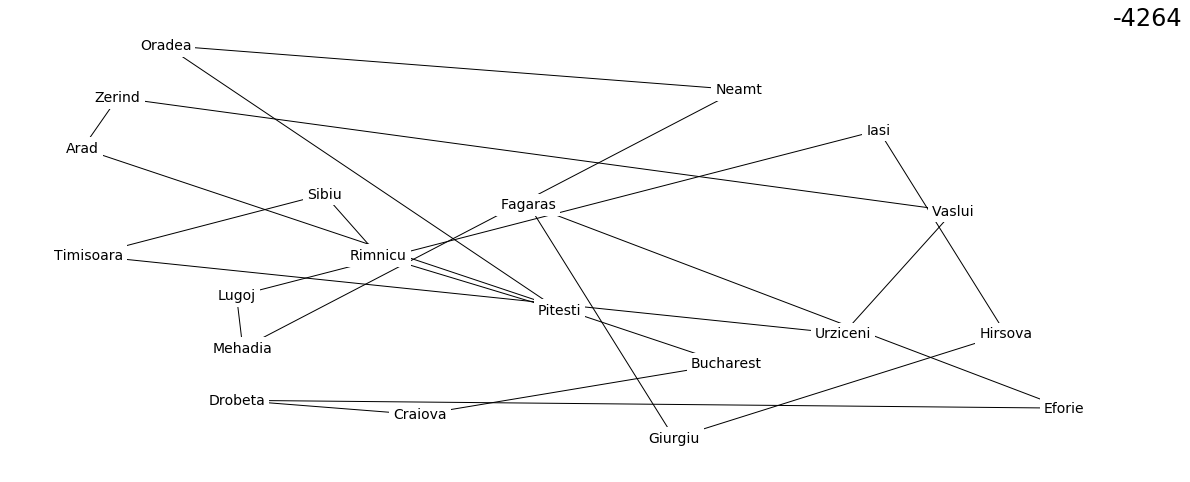

In [44]:
tsp = TSP(romania.cities, romania.distances, romania.locations)
tsp.display(tsp.initial)

Now let's approximate a solution using simulated annealing. First, we need a *schedule* that controls how long and fast the simulation cools. The schedule takes three parameters: An initial temperature, a `lambda` that determines the cool rate, the maximum number of iterations. 

In [45]:
psource(exp_schedule)
schedule = exp_schedule(k=100, lam=0.03, limit=1500)

We have everything to run the simulation and see how it did:

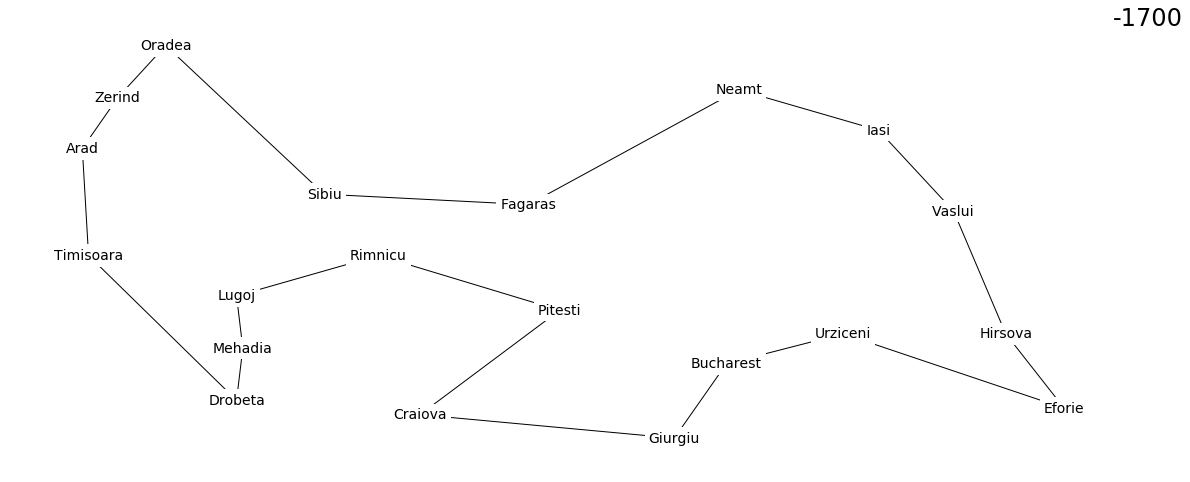

In [46]:
tsp.display(simulated_annealing(tsp,schedule))

To get an idea of how the simulation arrived at that solution, watch the visualization below:

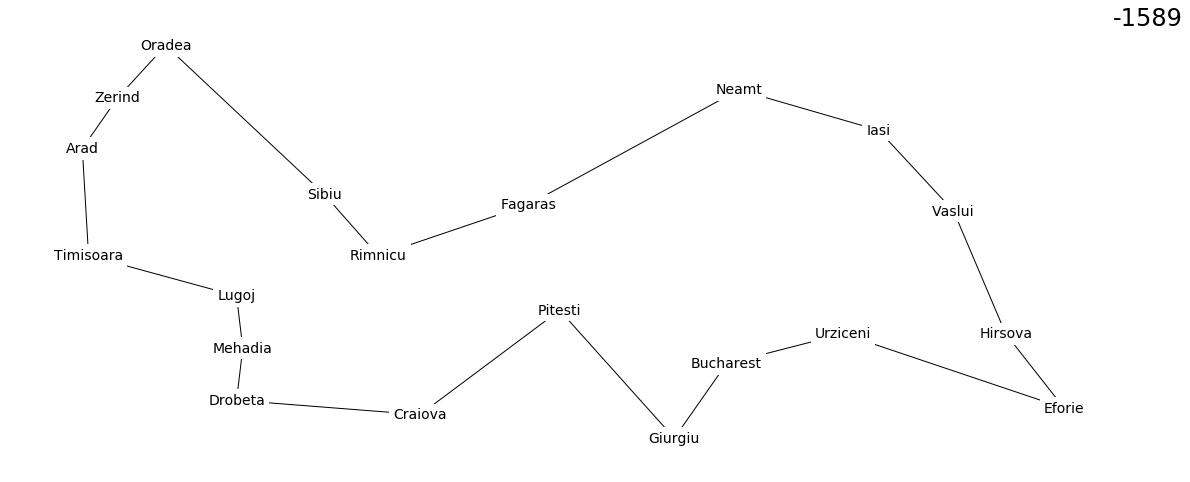

In [47]:
import time
from IPython import display

# returns all intermediate states
results = simulated_annealing_full(tsp,schedule)

for i in range(0,len(results)):
    if results[i] != results[i-1]:
        tsp.display(results[i])
        display.clear_output(wait=True)
        plt.show()
        time.sleep(0.25)

In [48]:
class QAP(Problem):
    # we need to read the flow data
    def __init__(self, flow_data):
        with open(flow_data) as infile:
            self.flows = QAP.init_flow(infile)
        Problem.__init__(self,QAP.init_locations(self.flows))
    
    def init_flow(infile):
        """
        Initialize and return the flow matrix.

        Reads the file pointed to by infile. The file must have the following
        format:

        Line x should contain the list of flow values from department x+1 to 
        departments 1 through x-1, each flow separated by whitespace. A blank line
        terminates the file, so file comments can be inserted after one or more
        blank lines.
        """

        flows = []
        for line in infile:
            if line.strip():
                flows.append([int(flow) for flow in line.split()])
            else:
                break

        return flows

    def init_locations(flows):
        """
        Set initial department locations randomly.
        """
        num_departments = len(flows) + 1 # flows doesn't have row for 1st department

        # assume rectangular layouts
        rows = math.floor(math.sqrt(num_departments))
        cols = math.ceil(num_departments / rows)

        dept_iter = iter(random.sample(range(num_departments), num_departments))

        return [[next(dept_iter) for col in range(cols)] for row in range(rows)]
    
    def swap(self, state):
        """
        Perturb the department arrangement by swapping two department locations. 
        Returns a tuple containing the locations swapped for use with undo swap, if
        necessary.
        """
        new_state = copy.deepcopy(state)
        
        x1 = random.choice(range(len(new_state)))
        y1 = random.choice(range(len(new_state[x1])))

        x2 = random.choice(range(len(new_state)))
        y2 = random.choice(range(len(new_state[x2])))

        while x1 == x2 and y1 == y2:
            x2 = random.choice(range(len(new_state)))
            y2 = random.choice(range(len(new_state[x2])))

        new_state[x1][y1], new_state[x2][y2] = new_state[x2][y2], new_state[x1][y1]

        return new_state
    
    # the only action to take is to try another random state
    def actions(self, state):
        return [self.swap(state)]
    
    # the only result is the next random state
    def result(self, state, action):
        return action

    # states cost the sum of the weighted manhattan distances
    def value(self, state):
        """
        Calculates the cost based on the rectilinear distance between the source
        and destination times the flow.
        """

        total_cost = 0

        # flow is symmetrical, so to avoid double-counting flow, we only count flow
        # from locations below each current location and exit the loop as soon as
        # it reaches the current location
        for r1, r1_depts in enumerate(state):
            for c1, dept1 in enumerate(r1_depts):
                try:
                    for r2, r2_depts in enumerate(state):
                        for c2, dept2 in enumerate(r2_depts):
                            if r2 == r1 and c2 == c1:
                                # break out of two inner loops
                                raise StopIteration
                            else:
                                # the flows lookup table is a half-matrix, so
                                # we have to make sure we use the largest department
                                # for the row and the smallest for the column
                                lo, hi = ((dept1, dept2) if dept1 < dept2 
                                                                else (dept2, dept1))
                                dist = abs(r2-r1) + abs(c2-c1)

                                # the half-matrix has no row for the first 
                                # department, so we subtract 1 from the dept number
                                # to get the correct row; we never have to worry
                                # about 0 being the hi_dept, since another
                                # department will always be higher and force 0 to
                                # the the lo_dept
                                total_cost += self.flows[hi-1][lo] * dist
                except StopIteration:
                    continue

        return total_cost

    # print the solution
    def display(self,state):
        print("Cost: {}".format(self.value(state)))
        for row in state:
            print(row)

In [49]:
qap = QAP("input.txt")
qap.display(simulated_annealing(qap))

Cost: 876
[6, 8, 9, 10, 1]
[13, 0, 3, 4, 14]
[11, 7, 2, 5, 12]


In [77]:
qap = QAP("input.txt")
schedule = exp_schedule(k=30, lam=0.0000005, limit=400000)
qap.display(simulated_annealing(qap, schedule))

Cost: 919
[6, 7, 11, 0, 12]
[8, 9, 3, 5, 2]
[14, 1, 13, 4, 10]
